# SALES DATA ANALYSIS

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import io


In [32]:
df = pd.read_csv(r"C:\Users\Akshaya\OneDrive\Desktop\Xcelerate\chat_gpt\sales_data.csv")
df['sales_date'] = pd.to_datetime(df['sales_date'])

print(df.head())

   order_id  product_id sales_date  quantity_sold  unit_price  total_sales
0        51          15 2024-02-21              3       45.67       137.01
1        52          17 2024-02-22              7       88.12       616.84
2        53          12 2024-02-23              2       91.45       182.90
3        54          15 2024-02-24              5       55.34       276.70
4        55          20 2024-02-25              6       84.56       507.36


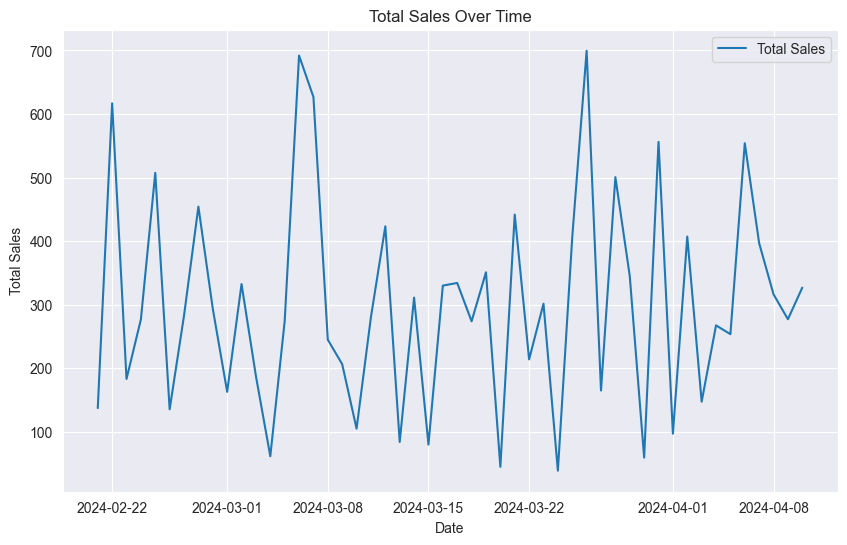

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(df["sales_date"], df['total_sales'], label='Total Sales')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

### ARIMA MODEL

                               SARIMAX Results                                
Dep. Variable:            total_sales   No. Observations:                   50
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -325.135
Date:                Sun, 23 Mar 2025   AIC                            662.270
Time:                        07:51:47   BIC                            673.621
Sample:                             0   HQIC                           666.576
                                 - 50                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9539      0.152     -6.280      0.000      -1.252      -0.656
ar.L2         -0.7644      0.225     -3.397      0.001      -1.206      -0.323
ar.L3         -0.5903      0.282     -2.090      0.0

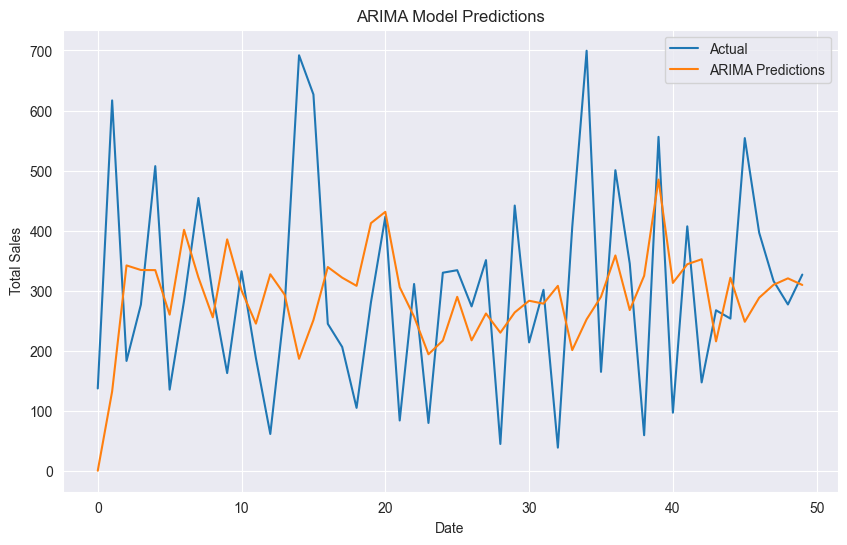

In [ ]:
model = ARIMA(df['total_sales'], order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['total_sales'], label='Actual')
plt.plot(df.index, model_fit.predict(start=0, end=len(df)-1, typ='levels'), label='ARIMA Predictions')
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

## GRU MODELS

c:\Users\Akshaya\OneDrive\Desktop\Xcelerate\.venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.0022
Epoch [20/100], Loss: 0.0125
Epoch [30/100], Loss: 0.0432
Epoch [40/100], Loss: 0.0397
Epoch [50/100], Loss: 0.0372
Epoch [60/100], Loss: 0.0077
Epoch [70/100], Loss: 0.0051
Epoch [80/100], Loss: 0.0031
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0020


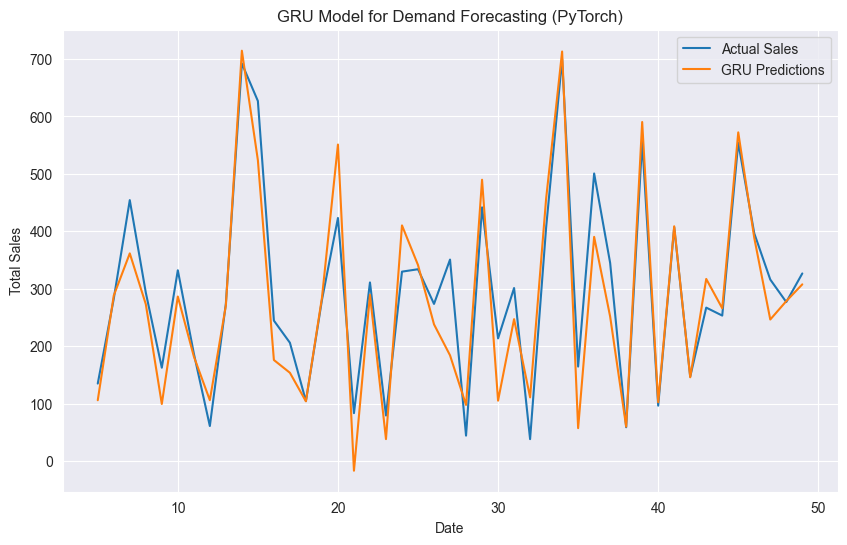

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


def create_dataset(data, look_back=3):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['total_sales']].values)


look_back = 5
X, Y = create_dataset(scaled_data, look_back)


X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  
Y = torch.tensor(Y, dtype=torch.float32)


dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)


class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  
        return out


input_size = 1  
hidden_size = 50
output_size = 1
model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


num_epochs = 100
for epoch in range(num_epochs):
    for batch_X, batch_Y in dataloader:
        
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


model.eval()
with torch.no_grad():
    train_predict = model(X).numpy()


train_predict = scaler.inverse_transform(train_predict)
Y = scaler.inverse_transform(Y.numpy().reshape(-1, 1))


plt.figure(figsize=(10, 6))
plt.plot(df.index[look_back:], Y, label='Actual Sales')
plt.plot(df.index[look_back:], train_predict, label='GRU Predictions')
plt.title('GRU Model for Demand Forecasting (PyTorch)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

## PROPHET MODEL

08:02:48 - cmdstanpy - INFO - Chain [1] start processing
08:02:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Training Completed


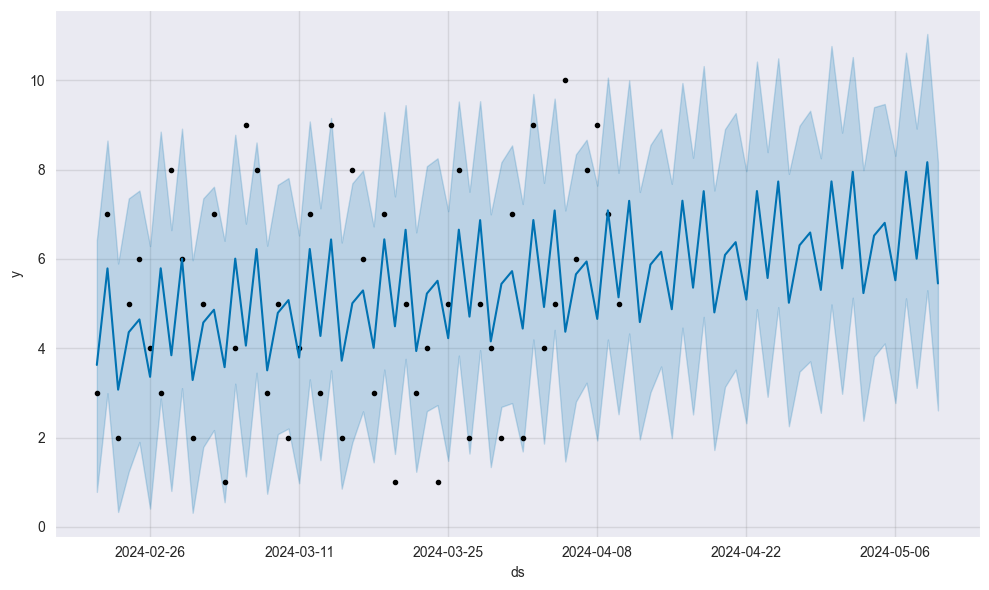

In [ ]:
from prophet import Prophet

prophet_df = df.rename(columns={"sales_date": "ds", "quantity_sold": "y"})
model_prophet = Prophet()
model_prophet.fit(prophet_df)
future = model_prophet.make_future_dataframe(periods=30)
forecast = model_prophet.predict(future)
model_prophet.plot(forecast)
print("Prophet Model Training Completed")